In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, MaxPooling1D, Dropout
from tensorflow.keras.layers import Bidirectional, GRU, Dense, Flatten
import numpy as np
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls '/content/drive/MyDrive/Colab Notebooks/voice_emotion_recognition/data/features/'

features.npy	 features_v5.npy  labels.npy	 labels_v5.npy
features_v4.npy  features_v6.npy  labels_v4.npy  labels_v6.npy


In [4]:
# ================================
# 2. Load Preprocessed Features
# ================================
X = np.load("/content/drive/MyDrive/Colab Notebooks/voice_emotion_recognition/data/features/features_v6.npy")   # shape: (1440, 3, 128, 173)
y = np.load("/content/drive/MyDrive/Colab Notebooks/voice_emotion_recognition/data/features/labels_v6.npy")   # shape: (1440,)

print("Original shapes ->", f"X: {X.shape}, y: {y.shape}")

Original shapes -> X: (1440, 3, 128, 173), y: (1440,)


In [5]:
# Transpose to shape (samples, timesteps, features)
X = np.transpose(X, (0, 3, 1, 2))         # (1440, 173, 3, 128)
X = X.reshape(X.shape[0], X.shape[1], -1) # (1440, 173, 384)

print("Reshaped X:", X.shape)

Reshaped X: (1440, 173, 384)


In [10]:
# ================================
# 3. One-Hot Encode Labels
# ================================
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded, num_classes=8)

In [13]:
# ================================
# 4. Train/Test Split
# ================================
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y, random_state=42)

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (1152, 173, 384) (1152, 8)
Test: (288, 173, 384) (288, 8)


In [14]:

model = Sequential([
    Input(shape=(173, 384)),  # (time_steps, features)

    Conv1D(128, kernel_size=5, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(256, kernel_size=5, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Bidirectional(GRU(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(GRU(64, return_sequences=False)),
    Dropout(0.4),

    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='softmax')
])


In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 173, 128)       │       245,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 173, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 86, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 86, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 86, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 86, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 43, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 43, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 43, 256)        │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 43, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       123,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 849,160 (3.24 MB)

 Trainable params: 848,392 (3.24 MB)

 Non-trainable params: 768 (3.00 KB)

In [19]:
# ================================
# 6. Callbacks
# ================================
callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True),
    ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/voice_emotion_recognition/src/model_architectures/emotional_model_v7.keras", save_best_only=True)
]

In [20]:
# ================================
# 7. Train the Model
# ================================
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=60,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/60
33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 578ms/step - accuracy: 0.1645 - loss: 2.1638 - val_accuracy: 0.1466 - val_loss: 2.0972
Epoch 2/60
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 489ms/step - accuracy: 0.1505 - loss: 2.1615 - val_accuracy: 0.0948 - val_loss: 2.1713
Epoch 3/60
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 549ms/step - accuracy: 0.1851 - loss: 2.0876 - val_accuracy: 0.0776 - val_loss: 2.1341
Epoch 4/60
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 524ms/step - accuracy: 0.1684 - loss: 2.0573 - val_accuracy: 0.1466 - val_loss: 2.0331
Epoch 5/60
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 562ms/step - accuracy: 0.2052 - loss: 1.9995 - val_accuracy: 0.1379 - val_loss: 2.1326
Epoch 6/60
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 486ms/step - accuracy: 0.1991 - loss: 1.9637 - val_accuracy: 0.1207 - val_loss: 2.2814
Epoch 7/60
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 536ms/step - accuracy: 0.2207 - loss: 1.8778 - val_accuracy: 0.1897 - val_loss: 2.0357
Epoch 8/60
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 681ms/step - accuracy: 0.2668 - loss: 1.8418 - val_accu

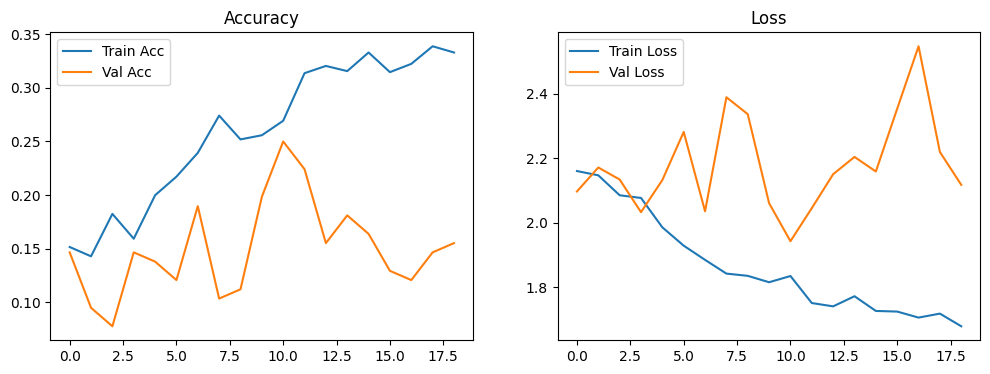

In [22]:
# ================================
# 11. Plot Training History
# ================================
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")
plt.show()

In [23]:
# ================================
# 8. Evaluate the Model
# ================================
loss, acc = model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest Accuracy: {acc:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.2922 - loss: 1.8826

Test Accuracy: 0.2986


In [24]:
# ================================
# 9. Classification Report
# ================================
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step

Classification Report:

              precision    recall  f1-score   support

       angry       0.42      0.39      0.41        38
        calm       0.33      0.55      0.42        38
     disgust       0.23      0.42      0.30        38
     fearful       0.35      0.21      0.26        39
       happy       0.15      0.05      0.08        39
     neutral       0.00      0.00      0.00        19
         sad       0.15      0.05      0.08        38
   surprised       0.31      0.56      0.40        39

    accuracy                           0.30       288
   macro avg       0.24      0.28      0.24       288
weighted avg       0.26      0.30      0.26       288



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


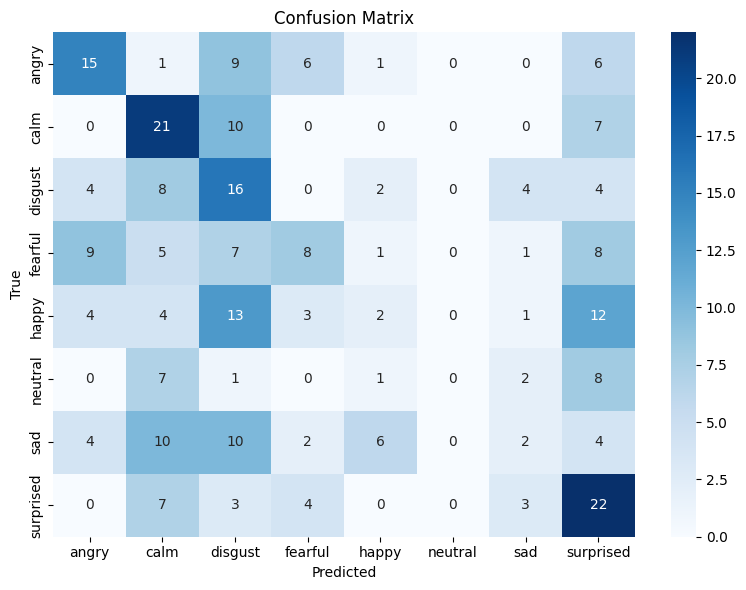

In [25]:
# ✅ 12. Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()